In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [141]:
from keras import backend, regularizers
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

In [3]:
import pickle
import matplotlib.pyplot as plt

In [4]:
from deepexplain.tensorflow import DeepExplain

In [5]:
print(backend.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [6]:
# data parameters
embedding_dims = 300

In [7]:
x_data = pickle.load(open("/mnt/hdd/datasets/imdb_glove_pickle/x_train.p", "rb"))
y_data = np.array(pickle.load(open("/mnt/hdd/datasets/imdb_glove_pickle/y_train.p", "rb")))

In [8]:
x_data_padded = pad_sequences(x_data, maxlen=512, dtype='float', padding='post')

In [29]:
x_train, x_val, y_train, y_val, idx_train, idx_val = train_test_split(
    x_data_padded, y_data, np.arange(len(x_data)), test_size=0.1, random_state=42)

In [10]:
# model parameters
dropout = 0.6
l2_reg = 1e-4

In [11]:
model_checkpoint = ModelCheckpoint('models/deepcnn.hdf5', monitor='val_acc', save_best_only=True)
callbacks_list = [model_checkpoint]

In [122]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3,
    activation='relu', input_shape=(512, embedding_dims),
    padding='same', kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(dropout))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', 
    padding='same', dilation_rate=2,
    kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(dropout))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', 
    padding='same', dilation_rate=4,
    kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(dropout))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', 
    padding='same', kernel_regularizer=regularizers.l2(l2_reg)))
model.add(GlobalAveragePooling1D())
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 512, 256)          230656    
_________________________________________________________________
dropout_45 (Dropout)         (None, 512, 256)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 512, 256)          196864    
_________________________________________________________________
dropout_46 (Dropout)         (None, 512, 256)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 512, 256)          196864    
_________________________________________________________________
dropout_47 (Dropout)         (None, 512, 256)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 512, 256)          196864    
__________

In [123]:
# training parameters
batch_size = 128
epochs = 20

In [124]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          callbacks=callbacks_list, validation_data=(x_val, y_val))

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 67s 3ms/step - loss: 0.5966 - acc: 0.7060 - val_loss: 0.3986 - val_acc: 0.8500
Epoch 2/20
22500/22500 [==============================] - 66s 3ms/step - loss: 0.3597 - acc: 0.8729 - val_loss: 0.3440 - val_acc: 0.8820
Epoch 3/20
22500/22500 [==============================] - 65s 3ms/step - loss: 0.3261 - acc: 0.8859 - val_loss: 0.3231 - val_acc: 0.8892
Epoch 4/20
22500/22500 [==============================] - 65s 3ms/step - loss: 0.2955 - acc: 0.8985 - val_loss: 0.3085 - val_acc: 0.8984
Epoch 5/20
22500/22500 [==============================] - 64s 3ms/step - loss: 0.2828 - acc: 0.9037 - val_loss: 0.3091 - val_acc: 0.8960
Epoch 6/20
22500/22500 [==============================] - 65s 3ms/step - loss: 0.2653 - acc: 0.9093 - val_loss: 0.3070 - val_acc: 0.8972
Epoch 7/20
22500/22500 [==============================] - 64s 3ms/step - loss: 0.2710 - acc: 0.9069 - val_loss: 0.2954 - val_acc:

In [143]:
del model
model = load_model('models/deepcnn.hdf5')

In [194]:
with DeepExplain(session=backend.get_session()) as de:
    input_tensor = model.layers[0].input
    
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_val[:500]
    ys = y_val[:500]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_sal = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)

In [ ]:
def explanation_correlation(expl1, expl2):
    for expl

In [195]:
attributions_gradin_summed = np.sum(attributions_gradin, axis=2)
attributions_sal_summed = np.sum(attributions_sal, axis=2)
attributions_ig_summed = np.sum(attributions_ig, axis=2)
attributions_elrp_summed = np.sum(attributions_elrp, axis=2)

In [196]:
input_index = 0
print(model.predict(np.expand_dims(x_val[input_index], axis=0)))

[[0.96962    0.03038005]]


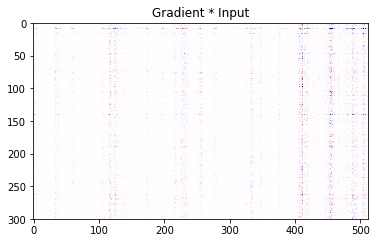

In [197]:
#plt.figure(figsize=(12.8,7.5))
gradin_input = np.transpose(attributions_gradin[input_index])
gradin_max = np.max(np.abs(gradin_input))
plt.title('Gradient * Input')
plt.imshow(gradin_input, cmap='seismic', interpolation='None', vmin=-gradin_max, vmax=gradin_max)
plt.savefig('images/gradient.eps')

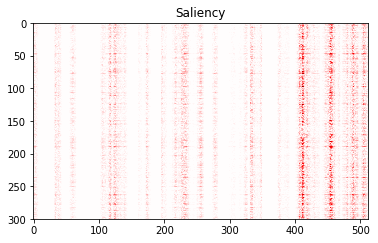

In [198]:
#plt.figure(figsize=(12.8,7.5))
sal_input = np.transpose(attributions_sal[input_index])
sal_max = np.max(np.abs(sal_input))
plt.title('Saliency')
plt.imshow(sal_input, cmap='seismic', vmin=-sal_max, vmax=sal_max)
plt.savefig('images/saliency.eps')

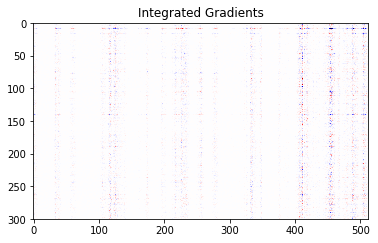

In [199]:
#plt.figure(figsize=(12.8,7.5))
ig_input = np.transpose(attributions_ig[input_index])
ig_max = np.max(np.abs(ig_input))
plt.title('Integrated Gradients')
plt.imshow(ig_input, cmap='seismic', vmin=-ig_max, vmax=ig_max)
plt.savefig('images/integrated_gradients.eps')

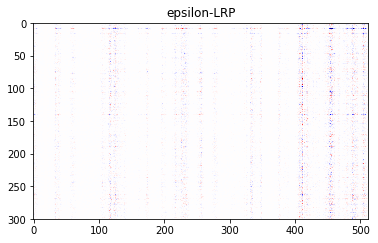

In [200]:
#plt.figure(figsize=(12.8,7.5))
elrp_input = np.transpose(attributions_elrp[input_index])
elrp_max = np.max(np.abs(elrp_input))
plt.title('epsilon-LRP')
plt.imshow(elrp_input, cmap='seismic', vmin=-elrp_max, vmax=elrp_max)
plt.savefig('images/epsilon_lrp.eps')

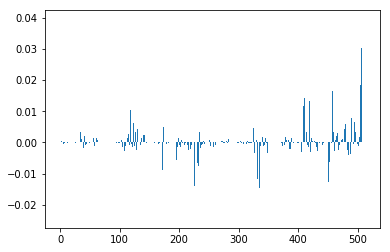

In [201]:
plt.bar(np.arange(512), attributions_gradin_summed[input_index])
plt.show()

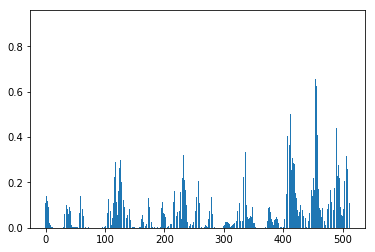

In [202]:
plt.bar(np.arange(512), attributions_sal_summed[input_index])
plt.show()

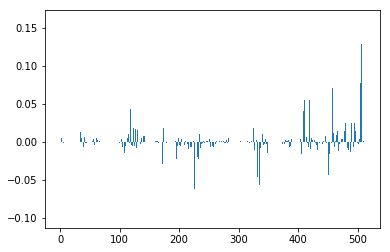

In [203]:
plt.bar(np.arange(512), attributions_ig_summed[input_index])
plt.show()

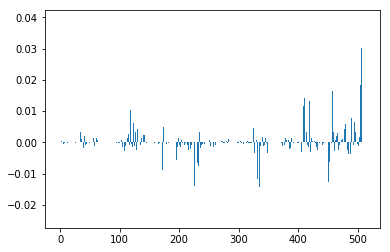

In [204]:
plt.bar(np.arange(512), attributions_elrp_summed[input_index])
plt.show()

In [225]:
print(np.corrcoef(np.sum(np.absolute(attributions_ig), axis=2).flatten(), attributions_sal_summed.flatten()))

[[1.         0.79669262]
 [0.79669262 1.        ]]


In [223]:
np.sum(np.absolute(attributions_gradin), axis=2).flatten().shape

(256000,)

In [206]:
index = idx_val[input_index]

In [207]:
import csv

In [208]:
with open('imdb_master.csv', encoding="latin-1") as csvFile:
    reader = csv.reader(csvFile)
    count=0
    for row in reader:
        if row[1] == 'train':
            if count==index:
                result=row
                break
            count += 1

In [209]:
print(result)

['31868', 'train', 'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />